# Decision Trees and Ensembles

# Forest Cover Prediction
In this assignment we are going to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). Cover_Type (7 types, integer 1 to 7). The seven types are:
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

"Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types)." [https://archive.ics.uci.edu/ml/datasets/covertype] 

In order to classify the forest cover, we will use several different classifiers and compare their results. The classifiers we will use are Decision Trees, Bagging, Boosting, and Random Forest. In this assignment you are suppose to use built-in classifiers from `sklearn`. The training, validation, and test partitions are provided. You may need to do some preprocessing, and of course hyper-parameter tuning for each classifier.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from itertools import product # this is to generate all possible combinations of parameters

C:\Users\Faisal\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
covtype = datasets.fetch_covtype()
X = covtype.data
Y = covtype.target

In [3]:
X.shape, Y.shape

((581012, 54), (581012,))

In [4]:
np.random.seed(0)
perm = np.random.permutation(581012)
trainx = X[perm[0:49500],:]
trainy = Y[perm[0:49500]]
valx = X[perm[49500:55000],:]
valy = Y[perm[49500:55000]]
testx = X[perm[55000:581012],:]
testy = Y[perm[55000:581012]]

In [5]:
sum(trainy==1), sum(trainy==2), sum(trainy==3), sum(trainy==4), sum(trainy==5), sum(trainy==6), sum(trainy==7)

(17945, 24251, 3023, 254, 786, 1481, 1760)

In [6]:
#generate all possible combinations of hyperparameters, given a hyperparameter grid
def generate_combinations(param_grid):
    keys, values = zip(*param_grid.items())
    for v in product(*values):
        yield dict(zip(keys, v))

# 1. Decision tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}


best_params_dt = None
best_score_dt = 0
best_dt = None

for params in generate_combinations(param_grid_dt):
    model = DecisionTreeClassifier(**params, random_state= 777)
    model.fit(trainx, trainy)
    predictions = model.predict(valx)
    score = accuracy_score(valy, predictions)

    if score > best_score_dt:
        best_score_dt = score
        best_params_dt = params
        best_dt = model

print("Decision Tree:")
print("Best Parameters:", best_params_dt)
print("Best Score on Validation Set:", best_score_dt)


Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Score on Validation Set: 0.8363636363636363


In [8]:
#test 
dt_test = best_dt.predict(testx)
dt_acc = accuracy_score(testy, dt_test)

print("accuracy for Decision Tree model: ", dt_acc)

accuracy for adaboost model:  0.8342680395124066


# 2. Bagging

In [9]:
from sklearn.ensemble import BaggingClassifier

param_grid_bag = {
    'n_estimators': [3, 5, 10], # I know this can be low, but this is just a proof of concept + to reduce complexity
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

best_params_bag = None
best_score_bag = 0
best_bag = None
base_model = DecisionTreeClassifier(random_state= 777)# define it here so that you don't make a decisiont tree each time
#iterate through all possible combinations of parameters and evaluate on the val set
for param in generate_combinations(param_grid_bag): 
    model = BaggingClassifier(base_estimator=base_model, **param, random_state= 777)
    model.fit(trainx, trainy)
    predictions = model.predict(valx)
    score = accuracy_score(valy, predictions)
    
    if score > best_score_bag:
        best_params_bag = param
        best_score_bag = score 
        best_bag = model

print("Bagging: ")
print("Best Parameters:", best_params_bag)
print("Best Score on Validation Set:", best_score_bag)

Bagging: 
Best Parameters: {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'bootstrap_features': False}
Best Score on Validation Set: 0.8825454545454545


In [10]:
#test
bag_test = best_bag.predict(testx)
bag_acc = accuracy_score(bag_test, testy)
print("accuracy for the bagging model: ", bag_acc)

accuracy for the bagging model:  0.880268891204003


# 3. AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
# training and hyper-parameter tuning

# Define the parameter grid for AdaBoost
param_grid_adaboost = { 
    'n_estimators': [3, 5, 10, 20, 50, 100, 200], #once again this is just a proof of concept, to reduce complexity.
    'learning_rate': [0.01, 0.1, 1.0] # other parameters can be added
}

best_params_ada = None
best_score_ada = 0
best_ada = None
base_model = DecisionTreeClassifier(random_state= 777) # define it here so that you don't make a decisiont tree each time
#iterate through all possible combinations of parameters and evaluate on the val set
for param in generate_combinations(param_grid_adaboost): 
    model = AdaBoostClassifier(base_estimator=base_model, **param, random_state= 777)
    model.fit(trainx, trainy)
    predictions = model.predict(valx)
    score = accuracy_score(valy, predictions)
    
    if score > best_score_ada:
        best_params_ada = param
        best_score_ada = score 
        best_ada = model

print("AdaBoost: ")
print("Best Parameters:", best_params_ada)
print("Best Score on Validation Set:", best_score_ada)

AdaBoost: 
Best Parameters: {'n_estimators': 3, 'learning_rate': 0.01}
Best Score on Validation Set: 0.8365454545454546


In [12]:
#test
ada_test = best_ada.predict(testx)
ada_acc = accuracy_score(testy, ada_test)
print("accuracy for adaboost model: ", ada_acc)

accuracy for adaboost model:  0.8325551508330609


# 4. Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [3, 5, 10], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2] 
}

best_param_rf = None 
best_score_rf = 0
best_rf = None

for param in generate_combinations(param_grid_rf): 
    model = RandomForestClassifier(random_state = 777, **param)
    model.fit(trainx, trainy)
    predictions = model.predict(valx)
    score = accuracy_score(valy, predictions)
    
    if score > best_score_rf:
        best_param_rf = param
        best_score_rf = score 
        best_rf = model

    
print("Random Forest: ")
print("Best Parameters:", best_param_rf)
print("Best Score on Validation Set:", best_score_rf)

Random Forest: 
Best Parameters: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best Score on Validation Set: 0.8556363636363636


In [14]:
#test
rf_pred = best_rf.predict(testx)
rf_acc = accuracy_score(rf_pred, testy)
print(rf_acc)

0.8567028889074774


## Questions:

Please report in you submission the following for each classifier:
1. The best result on the validaton set
2. Hyperparameter values for the classifier
3. The result on the test set.

the Answer is the data frame below

Apart from the above, please provide your comments and observations on the results of the different classifiers.


Answer: I think many models what have goten better performance if I did with parameter grid and added more to explore each model, but due to the lack of capabilities (my laptop isn't strong) and to save time as well I did this match, however this serves as a proof of concept that I can automate hyperparameter tuning. 


also the validation acc as well as the test acc are extremly similar to each model, which is a good thing I think making, since it may indicate the distribution is covered. if I had enough time I would change the data splitting multiple times

In [15]:
import pandas as pd 

data = {
    "model": ["Decision Tree", "Bagging", "AdaBoost", "RandomForest"],
    "parameters": [best_params_dt, best_params_bag, best_params_ada, best_param_rf],
    "validation set acc": [best_score_dt, best_score_bag, best_score_ada, best_score_rf],
    "test set acc": [dt_acc, bag_acc, ada_acc, rf_acc]
}

df = pd.DataFrame(data)

df.head()

,model,parameters,validation set acc,test set acc
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 30, 'min...",0.836364,0.834268
1,Bagging,"{'n_estimators': 10, 'max_samples': 1.0, 'max_...",0.882545,0.880269
2,AdaBoost,"{'n_estimators': 3, 'learning_rate': 0.01}",0.836545,0.832555
3,RandomForest,"{'n_estimators': 10, 'max_depth': None, 'min_s...",0.855636,0.856703


## EXTRA

Download the Statlog (Vehicle Silhouettes) Data Set (https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29)

It has 18 features and following four classes:
**OPEL, SAAB, BUS, VAN**

The purpose is to classify a given silhouette as one of four types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. 


Use Decision Tree classifer to train the classifier with train/val/test partition as 70/15/15 (random seed=777)
Fine-tune the tree on the validation set.

1. Report the performance on the test set
2. Extract the decision rules for classifiecation.
3. Plot the decision tree as an image using some library.

**Note:** You have library support in Python for visualizing the learnt decision trees.

In [16]:
df = pd.read_csv("Vehicles.csv")

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
#Stratify the data 
trainx, tempx, trainy, tempy = train_test_split(X, Y, test_size = 0.3, random_state = 777, stratify=Y)
testx, valx, testy, valy = train_test_split(tempx, tempy, test_size = 0.5, random_state = 777, stratify=tempy)


param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}


best_param = None 
best_score = 0
best_model = None

for param in generate_combinations(param_grid): 
    model = DecisionTreeClassifier(random_state = 777, **param)
    model.fit(trainx, trainy)
    predictions = model.predict(valx)
    score = accuracy_score(valy, predictions)

    
    if score > best_score:
        best_param = param
        best_score = score 
        best_model = model

    
print("Validation Set: ")
print("Best Parameters:", best_param)
print("Best Score on Validation Set:", best_score)

print()
test_pred = best_model.predict(testx)
test_acc = accuracy_score(testy, test_pred)
print("Test set: ")
print("The test set accuracy: ", test_acc)


Validation Set: 
Best Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}
Best Score on Validation Set: 0.8031496062992126

Test set: 
The test set accuracy:  0.7086614173228346


In [17]:
from sklearn.tree import export_text
tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules)

|--- 6 <= 7.50
|   |--- 401 <= 298.00
|   |   |--- 127 <= 137.50
|   |   |   |--- 100 <= 81.50
|   |   |   |   |--- 40 <= 48.50
|   |   |   |   |   |--- class: saab
|   |   |   |   |--- 40 >  48.50
|   |   |   |   |   |--- class: opel
|   |   |   |--- 100 >  81.50
|   |   |   |   |--- 20 <= 17.50
|   |   |   |   |   |--- 6.1 <= 16.50
|   |   |   |   |   |   |--- 36 <= 34.50
|   |   |   |   |   |   |   |--- class: saab
|   |   |   |   |   |   |--- 36 >  34.50
|   |   |   |   |   |   |   |--- 36 <= 35.50
|   |   |   |   |   |   |   |   |--- 19 <= 25.00
|   |   |   |   |   |   |   |   |   |--- 204 <= 193.50
|   |   |   |   |   |   |   |   |   |   |--- class: van
|   |   |   |   |   |   |   |   |   |--- 204 >  193.50
|   |   |   |   |   |   |   |   |   |   |--- class: van
|   |   |   |   |   |   |   |   |--- 19 >  25.00
|   |   |   |   |   |   |   |   |   |--- class: saab
|   |   |   |   |   |   |   |--- 36 >  35.50
|   |   |   |   |   |   |   |   |--- class: van
|   |   |   |   |   |--- 6

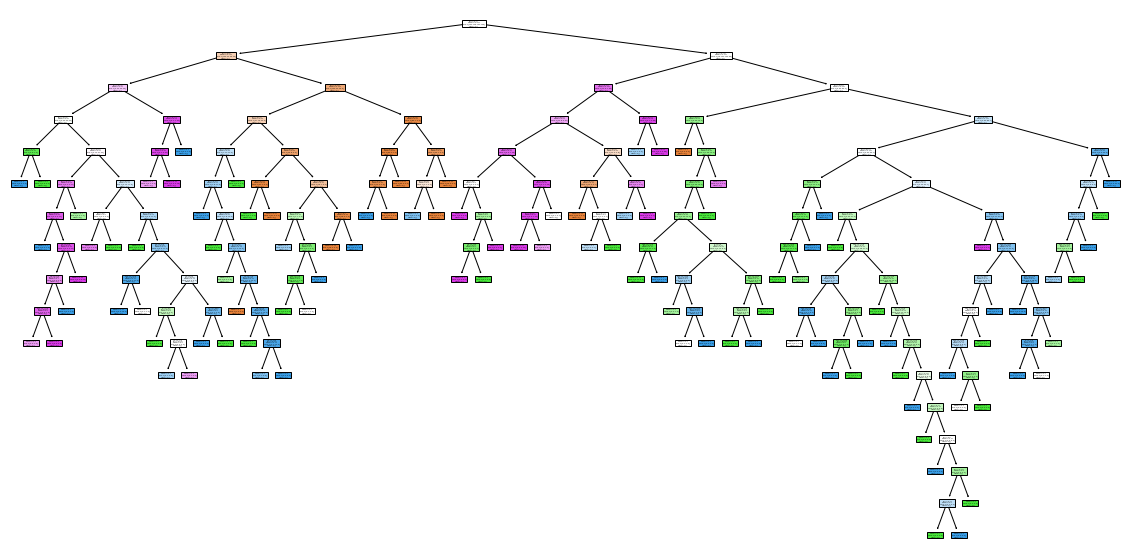

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X.columns, class_names=True, filled=True)
plt.show()


In [19]:
# I think the model is overfitting, maybe I need to use K-fold cross validation instead

from sklearn.model_selection import GridSearchCV


df = pd.read_csv("Vehicles.csv")

X = df.iloc[:, :-1]  
Y = df.iloc[:, -1]   

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777, stratify=Y)
#use similar grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=777), param_grid, cv=10, scoring='accuracy')

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score on Training Set:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(Y_test, test_predictions)
print("Test Set Accuracy:", test_accuracy)


Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Score on Training Set: 0.7766022827041265
Test Set Accuracy: 0.6923076923076923


|--- 40 <= 41.50
|   |--- 6 <= 7.50
|   |   |--- 40 <= 36.50
|   |   |   |--- class: bus
|   |   |--- 40 >  36.50
|   |   |   |--- 73.1 <= 67.00
|   |   |   |   |--- 200 <= 196.00
|   |   |   |   |   |--- 100 <= 89.50
|   |   |   |   |   |   |--- 125 <= 141.00
|   |   |   |   |   |   |   |--- class: saab
|   |   |   |   |   |   |--- 125 >  141.00
|   |   |   |   |   |   |   |--- class: opel
|   |   |   |   |   |--- 100 >  89.50
|   |   |   |   |   |   |--- 72 <= 72.00
|   |   |   |   |   |   |   |--- class: saab
|   |   |   |   |   |   |--- 72 >  72.00
|   |   |   |   |   |   |   |--- class: opel
|   |   |   |   |--- 200 >  196.00
|   |   |   |   |   |--- 40 <= 39.50
|   |   |   |   |   |   |--- class: bus
|   |   |   |   |   |--- 40 >  39.50
|   |   |   |   |   |   |--- class: opel
|   |   |   |--- 73.1 >  67.00
|   |   |   |   |--- class: bus
|   |--- 6 >  7.50
|   |   |--- 401 <= 721.50
|   |   |   |--- 204 <= 196.50
|   |   |   |   |--- 189 <= 225.50
|   |   |   |   |   |--- 19 <= 

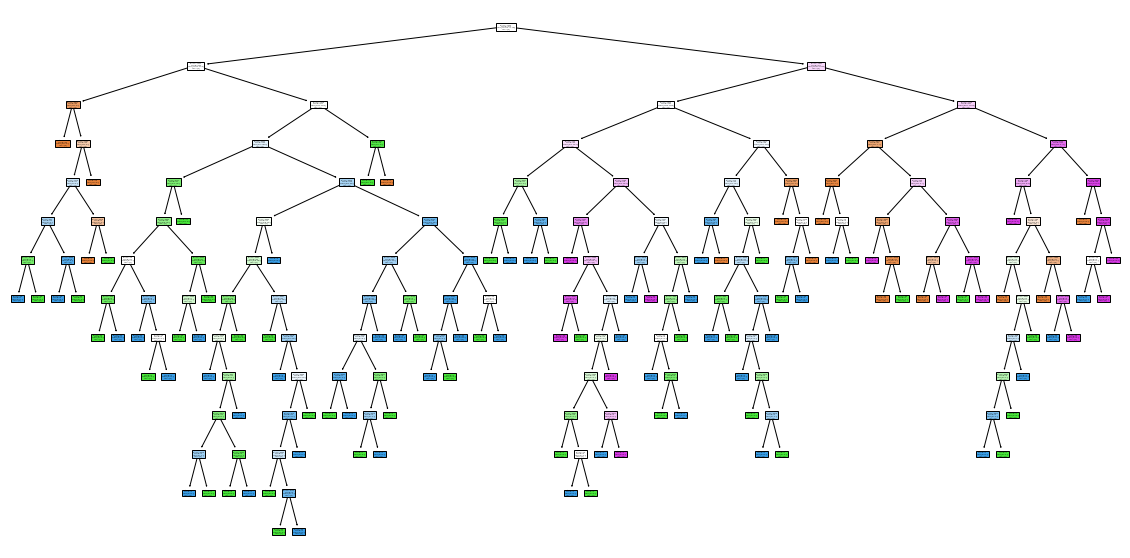

In [20]:
#I got worse results LOL 

tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules)



plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X.columns, class_names=True, filled=True)
plt.show()
